In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.api import OLS
import gpytorch
import torch
from GPPred import GPPred, ExactGPModel
from GPPred import CalibrateModels
from sklearn.metrics import mean_squared_error
%matplotlib inline

plt.style.use('seaborn-whitegrid')

/var/folders/l4/8m8mc77d711b218kpn3nm8sc0000gn/T/ipykernel_94370/1236611481.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [362]:
# # Define the function
# def non_smooth_function(x):
#     conditions = [x < -2, (x >= -2) & (x < 0), (x >= 0) & (x < 2), x >= 2]
#     functions = [lambda x: np.sin(x),  # Smooth, but with a jump to the next segment
#                  lambda x: -1,        # Constant, creating a jump from the previous segment
#                  lambda x: 0.5*x,     # Linear, creating a discontinuity from the constant segment
#                  lambda x: np.sin(x) + 2]  # Jump and offset from the previous linear segment
#     return np.piecewise(x, conditions, functions)

# # Generate sample data
# x = np.linspace(-10, 10, 400)
# y = non_smooth_function(x)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Non-Smooth Function')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Example of a Non-Smooth Function for GPR Challenges')
# plt.legend()
# plt.show()


In [363]:
def GP_predict(test_x, kernel_type, x, y, optimal_lengthscale, optimal_outputscale, optimal_noise):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1.000E-06))
    model = ExactGPModel(x, y, likelihood, kernel_type)

    # assign the optimal hyperparameters
    model.covar_module.base_kernel.lengthscale = optimal_lengthscale
    model.covar_module.outputscale = optimal_outputscale
    model.likelihood.noise = optimal_noise
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        observed_pred = model(test_x)
        observed_pred_with_noise = likelihood(observed_pred) 
    
    return observed_pred, observed_pred_with_noise


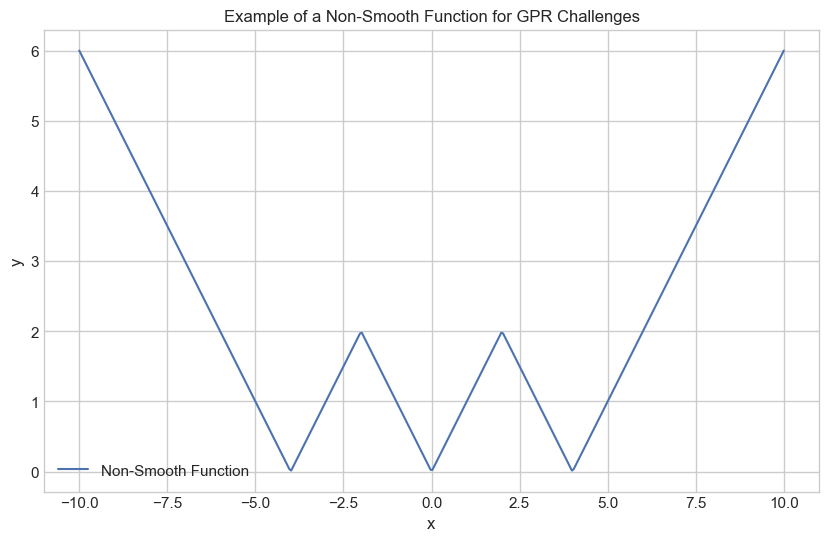

In [364]:
# Define the function
def non_smooth_function(x):
    conditions = [x<-4, (x >= -4) & (x < -2), (x >= -2) & (x < 0), (x >= 0) & (x < 2), (x >= 2) & (x < 4), x>4]
    functions = [
                 lambda x: -x - 4,  # Smooth, but with a jump to the next segment
                 lambda x: 4 + x,  # Smooth, but with a jump to the next segment
                 lambda x: -x,        # Constant, creating a jump from the previous segment
                 lambda x: x,     # Linear, creating a discontinuity from the constant segment
                 lambda x: 4 - x,  # Jump and offset from the previous linear segment
                 lambda x: x - 4
    ]
    return np.piecewise(x, conditions, functions)

# Generate sample data
x = np.linspace(-10, 10, 400)
y = non_smooth_function(x)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Non-Smooth Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example of a Non-Smooth Function for GPR Challenges')
plt.legend()
plt.show()


In [365]:
# # Define the function
# def more_non_smooth_function(x):
#     conditions = [
#         x < -5,                                      # Region 1
#         (x >= -5) & (x < -2),                        # Region 2
#         (x >= -2) & (x < 0),                         # Region 3
#         (x >= 0) & (x < 2),                          # Region 4
#         (x >= 2) & (x < 5),                          # Region 5
#         x >= 5                                        # Region 6
#     ]
#     functions = [
#         lambda x: np.abs(x) - 5,                     # Absolute value, creating a corner at x = -5
#         lambda x: np.sin(3*x),                       # High frequency sine wave for complexity
#         lambda x: np.log(np.abs(x+2)),               # Logarithmic, introducing a vertical asymptote at x = -2
#         lambda x: 2 * np.piecewise(x, [x < 1, x >= 1], [lambda x: x, lambda x: 0]), # Piecewise linear with a break
#         lambda x: -2 + (x-2)**2,                     # Quadratic, smooth but with a different curvature
#         lambda x: 20 * np.sin(x) / x                 # Sinc function, introducing oscillations
#     ]
#     return np.piecewise(x, conditions, functions)

# # Generate sample data
# x = np.linspace(-10, 10, 1000)
# y = more_non_smooth_function(x)

# # Plot
# plt.figure(figsize=(12, 7))
# plt.plot(x, y, label='More Non-Smooth Function')
# plt.xlabel('x')
# plt.ylabel('y')



### Data Mismeasurement

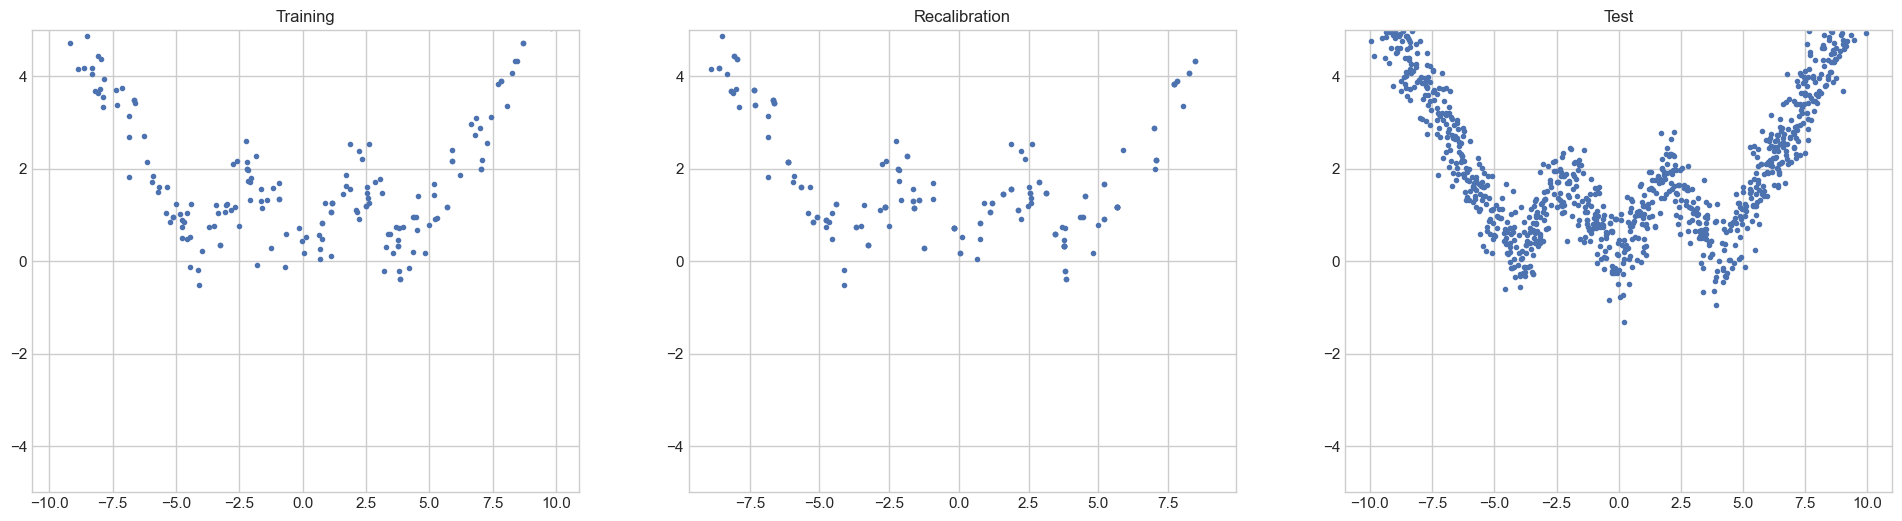

In [366]:
n = 4000
n_per = 1000
x = np.linspace(-10, 10, n)
# y = 0.00005*x**5*(np.abs(x))*np.cos(x)*np.log(np.abs(x)) + np.random.normal(scale=1.0,size=n)
# y = 0.00005*x**7 + np.random.normal(scale=0.5,size=n)
np.random.seed(123)
y = non_smooth_function(x) + np.random.normal(scale=0.5,size=n)
# use noise from student-t distribution instead of normal
# y = non_smooth_function(x) + 0.5*st.t.rvs(3, size=n)
# eval and test dataset
x, x_test, y, y_test = train_test_split(x,y,train_size=0.5)
x, x_eval, y, y_eval = train_test_split(x,y,train_size=0.5)
x_test, y_test = x_test[0:n_per], y_test[0:n_per]

# downsample x, y using only 0.3 of the data
x, y = resample(x,y,n_samples=int(0.05*n))



add_noise = 0.00
# adding some noise
y_eval += np.random.normal(scale=add_noise,size=n_per)
y_test += np.random.normal(scale=add_noise,size=n_per)



# sorting
inds_x, inds_eval, inds_test = np.argsort(x), np.argsort(x_eval), np.argsort(x_test)
x, y = x[inds_x], y[inds_x]
x_eval, y_eval = x_eval[inds_eval], y_eval[inds_eval]
x_test, y_test = x_test[inds_test], y_test[inds_test]


# # downsample x_eval, y_eval using only 0.1 of the data from beginning , middle and end 
x_eval, y_eval = resample(x,y,n_samples=int(0.05*n))
# sample_size = 0.05
# steps_1 = 2
# steps_2 = 10
# tmp_x_eval, tmp_y_eval = x_eval[0:int(sample_size*n):
# steps_1], y_eval[0:int(sample_size*n):steps_1]
# tmp_x_eval, tmp_y_eval = np.append(tmp_x_eval, x_eval[int(sample_size*n):-int(sample_size*n):steps_2]), np.append(tmp_y_eval, y_eval[int(sample_size*n):-int(sample_size*n):steps_2])
# x_eval, y_eval = np.append(tmp_x_eval, x_eval[-int(sample_size*n):-1:steps_1]), np.append(tmp_y_eval, y_eval[-int(sample_size*n):-1:steps_1])

# assert x.shape == x_eval.shape and x_eval.shape == x_test.shape and x_test.shape[0] == n_per

# plotting x and y
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))


y_lower_lim = -5
y_upper_lim = 5
# training
ax[0].plot(x, y, 'o', markersize=3)
ax[0].set_title('Training')
ax[0].set_ylim([y_lower_lim, y_upper_lim])

# eval
ax[1].plot(x_eval, y_eval, 'o', markersize=3)
ax[1].set_title('Recalibration')
ax[1].set_ylim([y_lower_lim, y_upper_lim])
ax[1].set_xlim([x[0], x[-1]])

# test
ax[2].plot(x_test, y_test, 'o', markersize=3)
ax[2].set_title('Test')
ax[2].set_ylim([y_lower_lim, y_upper_lim]);

---

### Gaussian Processes Regression

In [367]:
# transform all data to tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()
x_eval = torch.tensor(x_eval).float()
y_eval = torch.tensor(y_eval).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()


In [368]:
kernel_type = 'Matern5/2'
GP = GPPred(x, y, kernel_type=kernel_type)
GP.trainGP(n_iter = 100)

# simple the misspecification
# GP.model.covar_module.outputscale = GP.model.covar_module.outputscale
# GP.model.covar_module.outputscale  = torch.Tensor([8.0])
# GP.model.likelihood.noise = GP.model.likelihood.noise * 0.01
optimal_lengthscale = GP.model.covar_module.base_kernel.lengthscale.detach()
optimal_outputscale = GP.model.covar_module.outputscale.detach()
optimal_noise = GP.model.likelihood.noise.detach()
print(GP.model.covar_module.outputscale, GP.model.covar_module.base_kernel.lengthscale, GP.model.likelihood.noise)
GP.model.covar_module.base_kernel.lengthscale = GP.model.covar_module.base_kernel.lengthscale * 10
GP.model.covar_module.outputscale = GP.model.covar_module.outputscale * 1
GP.model.likelihood.noise = GP.model.likelihood.noise * 1


# predict on the training set
y_pred_dist, y_pred_with_noise_dist = GP.predict(x)
y_pred = y_pred_dist.mean
y_pred_std = y_pred_with_noise_dist.stddev


# predict on the evaluation set
y_eval_pred_dist, y_eval_pred_with_noise_dist = GP.predict(x_eval)
y_eval_pred = y_eval_pred_dist.mean
y_eval_pred_std = y_eval_pred_with_noise_dist.stddev



# predict on the test set
# GP.model.covar_module.base_kernel.lengthscale = torch.Tensor([2.633])
y_test_pred_dist, y_test_pred_with_noise_dist = GP.predict(x_test)
y_test_pred = y_test_pred_dist.mean
y_test_pred_std = y_test_pred_with_noise_dist.stddev
lower, upper = y_test_pred - 1.96*y_test_pred_std, y_test_pred + 1.96*y_test_pred_std



# transform all data to back to numpy
x = x.numpy()
y = y.numpy()
x_eval = x_eval.numpy()
y_eval = y_eval.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()
y_pred = y_pred.numpy()
y_pred_std = y_pred_std.numpy()
y_eval_pred = y_eval_pred.numpy()
y_eval_pred_std = y_eval_pred_std.numpy()
y_test_pred = y_test_pred.numpy()
y_test_pred_std = y_test_pred_std.numpy()
lower = lower.numpy()
upper = upper.numpy()

tensor(3.9200, grad_fn=<SoftplusBackward0>) tensor([[2.7340]], grad_fn=<SoftplusBackward0>) tensor([0.2473], grad_fn=<AddBackward0>)


/opt/homebrew/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


78.6% of the points in the 95% PI


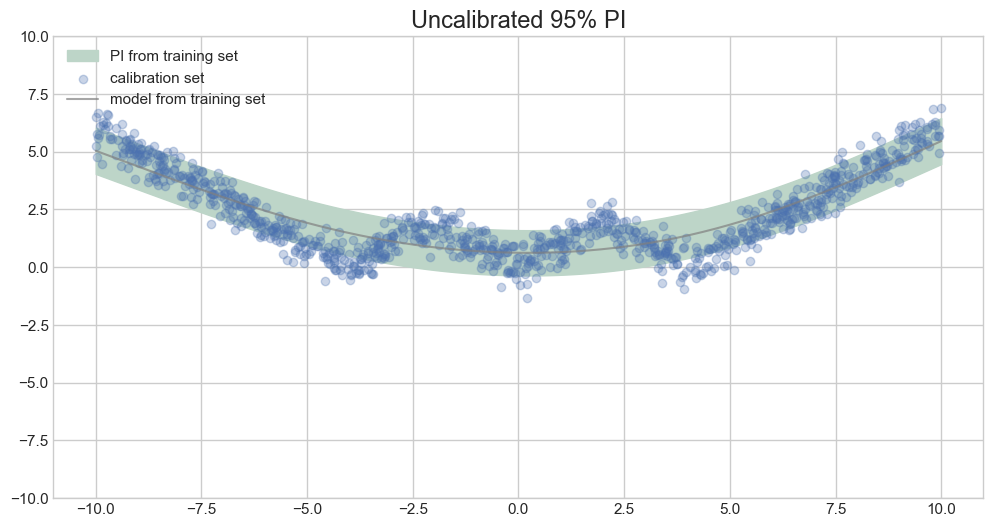

In [369]:
CalibrateModel = CalibrateModels()
CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper)


In [370]:
# y_test_pred_dist, y_test_pred_with_noise_dist = GP_predict(torch.Tensor(x_test), kernel_type, torch.Tensor(x), torch.Tensor(y), optimal_lengthscale, optimal_outputscale, optimal_noise)
# y_test_pred = y_test_pred_dist.mean.numpy()
# y_test_pred_std = y_test_pred_with_noise_dist.stddev.numpy()
# lower, upper = y_test_pred - 1.96*y_test_pred_std, y_test_pred + 1.96*y_test_pred_std

# CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper)

,x_eval,y_eval,h_xt_yt_sm,P_hat_sm
0,-9.994999,6.493671,0.997755,0.979
1,-9.984996,5.231849,0.652371,0.615
2,-9.969993,4.756653,0.302859,0.400
3,-9.964992,5.750535,0.923850,0.825
4,-9.949987,5.610544,0.880671,0.780


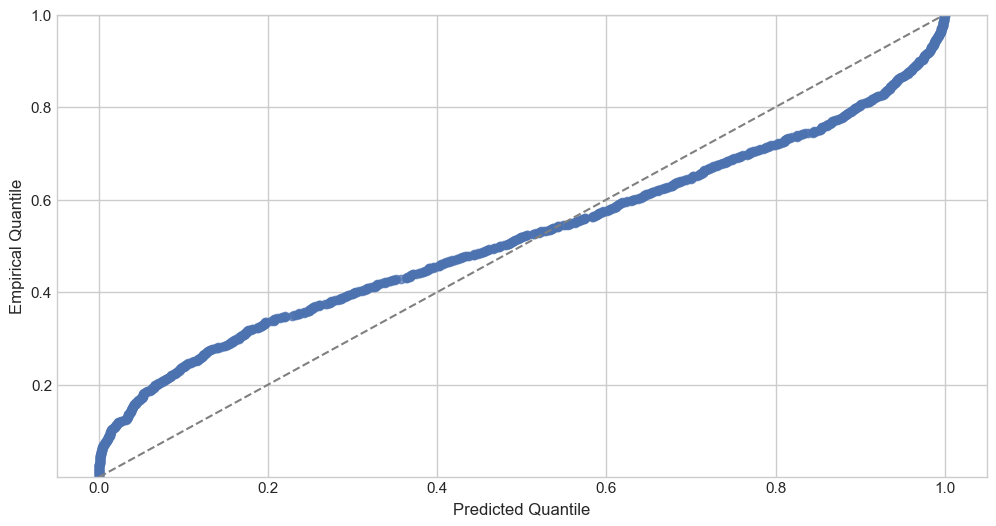

In [371]:
CalibrateModel.plot_quantiles(x_test, y_test, y_test_pred, y_test_pred_std)

### Model misspecification

We have chosen the wrong model. A smooth kernel should be chosen wnile a
non-smooth kernel was chosen. 

In [372]:
# compute RMSE for train, eval and test by hand
rmse_train = np.sqrt(np.mean((y - y_pred)**2))
rmse_eval = np.sqrt(np.mean((y_eval - y_eval_pred)**2))
rmse_test = np.sqrt(np.mean((y_test - y_test_pred)**2))
print(rmse_train, rmse_eval, rmse_test)


0.8223106 0.79402846 0.7891984


In [373]:
GPpredict = lambda xeval, lengthscale: GP_predict(torch.Tensor(xeval), kernel_type, torch.Tensor(x), torch.Tensor(y), lengthscale, GP.model.covar_module.outputscale, GP.model.likelihood.noise)

def adjust_lengthscale_trials(GP, GPpredict, x_eval, y_eval, c_decrease=0.5, c_increase=2, trials=100):
    # Store original lengthscale
    original_lengthscale = GP.model.covar_module.base_kernel.lengthscale.item()
    best_lengthscale = original_lengthscale
    min_rmse = float('inf')
    best_p_value = 0
    
    # Dictionary to store trial results
    trial_results = {}

    # Function to calculate RMSE
    def calc_rmse(actual, predicted):
        return np.sqrt(mean_squared_error(actual, predicted))

    # Initial prediction to get the starting performance metrics
    y_eval_pred_dist, _ = GPpredict(torch.Tensor(x_eval), original_lengthscale)
    y_eval_pred = y_eval_pred_dist.mean.numpy()
    initial_ks_test = st.ks_2samp(y_eval, y_eval_pred)
    initial_rmse = calc_rmse(y_eval, y_eval_pred)
    trial_results[original_lengthscale] = (initial_ks_test.pvalue, initial_rmse)

    # Decrease lengthscale trials
    temp_lengthscale = original_lengthscale
    for _ in range(trials):
        temp_lengthscale *= c_decrease
        y_eval_pred_dist, _ = GPpredict(torch.Tensor(x_eval), temp_lengthscale)
        y_eval_pred = y_eval_pred_dist.mean.numpy()
        ks_test = st.ks_2samp(y_eval, y_eval_pred)
        rmse = calc_rmse(y_eval, y_eval_pred)
        trial_results[temp_lengthscale] = (ks_test.pvalue, rmse)

    # Reset lengthscale to original before increasing
    temp_lengthscale = original_lengthscale

    # Increase lengthscale trials
    for _ in range(trials):
        temp_lengthscale *= c_increase
        y_eval_pred_dist, _ = GPpredict(torch.Tensor(x_eval), temp_lengthscale)
        y_eval_pred = y_eval_pred_dist.mean.numpy()
        ks_test = st.ks_2samp(y_eval, y_eval_pred)
        rmse = calc_rmse(y_eval, y_eval_pred)
        trial_results[temp_lengthscale] = (ks_test.pvalue, rmse)

    # Select the best lengthscale based on p-value > 0.05 and lowest RMSE
    for lengthscale, (p_value, rmse) in trial_results.items():
        if p_value > 0.05 and rmse < min_rmse:
            best_lengthscale, best_p_value, min_rmse = lengthscale, p_value, rmse

    # Update GP model with the best lengthscale
    GP.model.covar_module.base_kernel.lengthscale = best_lengthscale
    
    print(f"Best lengthscale: {best_lengthscale}, with p-value: {best_p_value} and RMSE: {min_rmse}")
    
    return GP, best_lengthscale, trial_results



GP, best_lengthscale, p_values = adjust_lengthscale_trials(GP, GPpredict, x_eval, y_eval, c_decrease=0.99, c_increase=1.01, trials=300)

Best lengthscale: 1.3407662655936325, with p-value: 0.6284308022715471 and RMSE: 0.4307919144630432


In [374]:
GPpredict1 = lambda xeval: GP_predict(torch.Tensor(xeval), kernel_type, torch.Tensor(x), torch.Tensor(y), best_lengthscale, GP.model.covar_module.outputscale, GP.model.likelihood.noise)


96.1% of the points in the 95% PI


/opt/homebrew/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


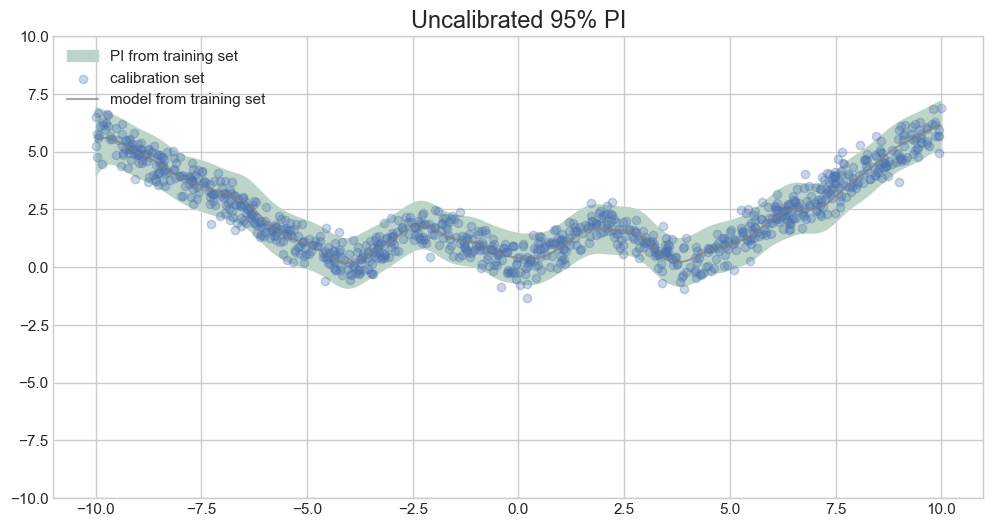

In [375]:
# repredict on train, eval and test
y_pred_dist, y_pred_with_noise_dist = GPpredict1(torch.Tensor(x))
y_pred = y_pred_dist.mean.numpy() 
y_pred_std = y_pred_with_noise_dist.stddev.numpy()

y_eval_pred_dist, y_eval_pred_with_noise_dist = GPpredict1(torch.Tensor(x_eval))
y_eval_pred = y_eval_pred_dist.mean.numpy() 
y_eval_pred_std = y_eval_pred_with_noise_dist.stddev.numpy()

y_test_pred_dist, y_test_pred_with_noise_dist = GPpredict1(torch.Tensor(x_test))
y_test_pred = y_test_pred_dist.mean.numpy()
y_test_pred_std = y_test_pred_with_noise_dist.stddev.numpy()
lower, upper = y_test_pred - 1.96*y_test_pred_std, y_test_pred + 1.96*y_test_pred_std
CalibrateModel = CalibrateModels()
CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper)

In [376]:
# compute the miscalibration defined to be sum(pow(y-mean/std, 2))
train_miscalibration = np.sum(np.power((y - y_pred)/y_pred_std, 2))/len(y)
print(f'Miscalibration on train set: {train_miscalibration:.2f}')

# compute the miscalibration defined to be sum(pow(y-mean/std, 2))
miscalibration = np.sum(np.power((y_eval - y_eval_pred)/y_eval_pred_std, 2))/len(y_eval)
print(f'Miscalibration on calibration set: {miscalibration:.2f}')

# compute the miscalibration defined to be sum(pow(y-mean/std, 2))
test_miscalibration = np.sum(np.power((y_test - y_test_pred)/y_test_pred_std, 2))/len(y_test)
print(f'Miscalibration on test set: {test_miscalibration:.2f}')

Miscalibration on train set: 0.73
Miscalibration on calibration set: 0.66
Miscalibration on test set: 0.91


In [377]:
# Do the first calibration on the calibration set
# scale the lengthscale, outputscale and noise by the mmiscalibration
# (l, o, n) -> (l, m*o, m*n)
calibration_scaling = miscalibration
print('before calibration outputscale: %.2f, noise: %.2f, lengthscale: %.2f ' %(GP.model.covar_module.outputscale.item(), GP.model.likelihood.noise.item(), GP.model.covar_module.base_kernel.lengthscale.item()))
calibrated_outputscale = GP.model.covar_module.outputscale*calibration_scaling
calibrated_noise = GP.model.likelihood.noise*calibration_scaling
print('after calibration outputscale: %.2f, noise: %.2f, lengthscale: %.2f ' %(calibrated_outputscale, calibrated_noise, best_lengthscale))

before calibration outputscale: 3.92, noise: 0.25, lengthscale: 1.34 
after calibration outputscale: 2.58, noise: 0.16, lengthscale: 1.34 


In [378]:
GPpredict2 = lambda xeval: GP_predict(torch.Tensor(xeval), kernel_type, torch.Tensor(x), torch.Tensor(y), best_lengthscale, calibrated_outputscale, calibrated_noise)

In [379]:
y_pred_dist, y_pred_with_noise_dist = GPpredict2(torch.Tensor(x))
y_pred_std = np.sqrt(y_pred_dist.variance.numpy() + calibrated_noise.item())
train_miscalibration = np.sum(np.power((y - y_pred)/y_pred_std, 2))/len(y)
print(f'Miscalibration on train set after calibration: {train_miscalibration:.2f}')


# compute the miscallibration using the recalibrated model on eval set and test set
y_eval_pred_dist, y_eval_pred_with_noise_dist = GPpredict2(torch.Tensor(x_eval))
y_eval_pred = y_eval_pred_dist.mean.numpy()
y_eval_pred_std = np.sqrt(y_eval_pred_dist.variance.numpy() + calibrated_noise.item())
eval_miscalibration = np.sum(np.power((y_eval - y_eval_pred)/y_eval_pred_std, 2))/len(y_eval)
print(f'Miscalibration on calibration set after calibration: {eval_miscalibration:.2f}')


y_test_pred_dist, y_test_pred_with_noise_dist = GPpredict2(torch.Tensor(x_test))
y_test_pred = y_test_pred_dist.mean.numpy()
y_test_pred_std = np.sqrt(y_test_pred_dist.variance.numpy() + calibrated_noise.item())
lower, upper = lower, upper = y_test_pred - 1.96*y_test_pred_std, y_test_pred + 1.96*y_test_pred_std
test_miscalibration = np.sum(np.power((y_test - y_test_pred)/y_test_pred_std, 2))/len(y_test)
print(f'Miscalibration on test set: {test_miscalibration:.2f}')

Miscalibration on train set after calibration: 1.11
Miscalibration on calibration set after calibration: 1.00
Miscalibration on test set: 1.39


89.9% of the points in the 95% PI


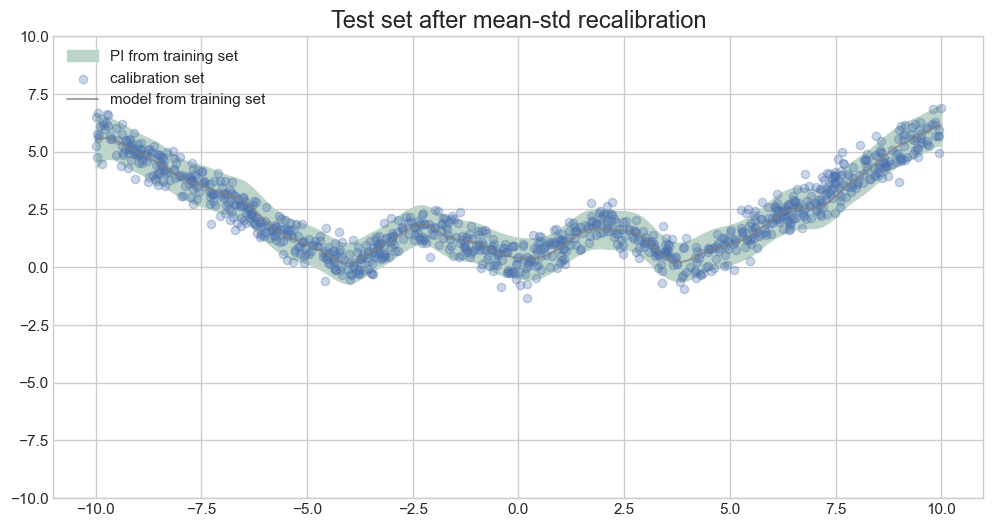

In [380]:
CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper, title='Test set after mean-std recalibration')


,x_eval,y_eval,h_xt_yt_sm,P_hat_sm
0,-9.994999,6.493671,0.954331,0.925
1,-9.984996,5.231849,0.343640,0.358
2,-9.969993,4.756653,0.107699,0.157
3,-9.964992,5.750535,0.668796,0.661
4,-9.949987,5.610544,0.570868,0.570


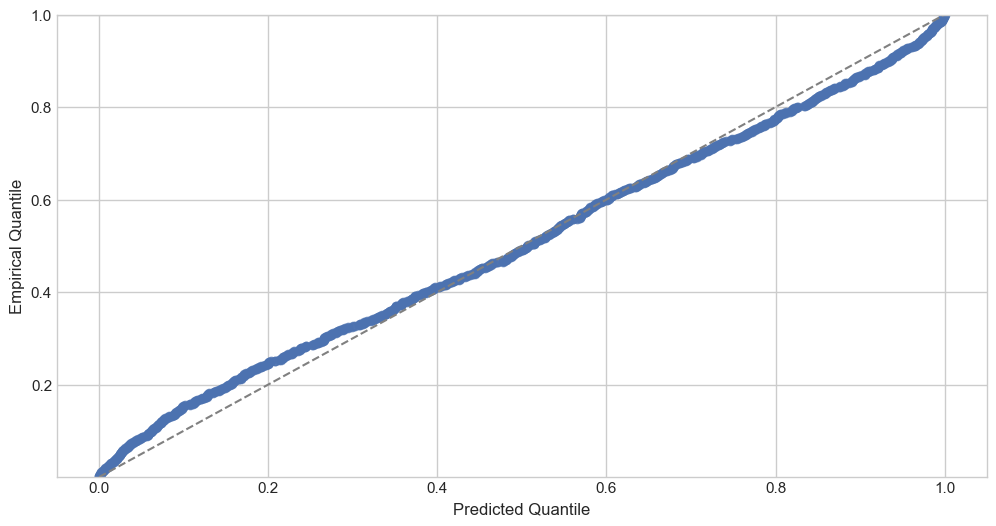

In [381]:
CalibrateModel.plot_quantiles(x_test, y_test, y_test_pred, y_test_pred_std)

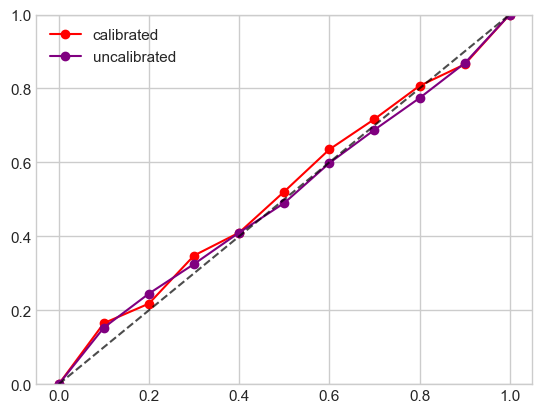

In [382]:
calibrator, calibrated_y_test_pred, lower, upper = CalibrateModel.plot_calibration_curve(y_eval, y_eval_pred, y_eval_pred_std, y_test, y_test_pred, y_test_pred_std)

90.4% of the points in the 95% PI


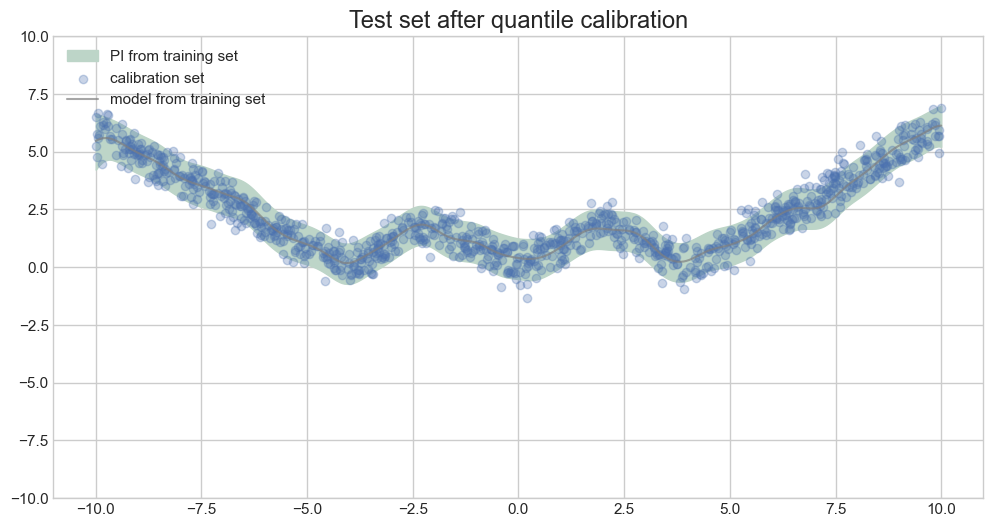

In [383]:
CalibrateModel.plot_CI(x_test, y_test, y_test_pred, lower, upper, title='Test set after quantile calibration')